In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from imblearn.over_sampling import RandomOverSampler
import joblib

In [2]:
# NLTK downloads
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# Step 1: Load Dataset
df = pd.read_csv("netflix_reviews.csv")
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,a958632f-ab4a-41d8-8eff-4b867b10ff9c,Gaurav Parikh,gauravparikh,5,0,8.4.0 build 12 40035,2025-07-01 09:42:56,8.4.0 build 12 40035
1,9a8bc879-b223-4dda-acc0-7dda595bc622,Kory BlackBuzzardBlvdMusic Knight,Take away the stupid household feature. someth...,3,0,9.21.0 build 5 62896,2025-06-30 04:19:52,9.21.0 build 5 62896
2,cb5e1b2f-664a-4ba1-b0dd-e6720079cfd1,Gaurav Parikh,gauravparikh,5,0,8.4.0 build 12 40035,2025-06-27 11:42:39,8.4.0 build 12 40035
3,152b237f-d43b-4958-afac-d62964df1b12,Paweł Ciechański,"was banned from service for no reason, it does...",1,0,9.20.0 build 8 62860,2025-06-27 11:15:56,9.20.0 build 8 62860
4,80e5fee1-7a35-411e-aed4-0cff2e9255e7,Syamil Satri,26 June 2025. please change back the user inte...,1,0,9.12.0 build 5 62504,2025-06-26 13:10:21,9.12.0 build 5 62504


In [4]:
df.isnull().sum()

reviewId                    0
userName                    2
content                     6
score                       0
thumbsUpCount               0
reviewCreatedVersion    23668
at                          0
appVersion              23668
dtype: int64

In [5]:
df.duplicated().sum()

287

In [6]:
# Step 2: Drop missing reviews
df = df.dropna(subset=['content'])

In [7]:
# Check if nulls are removed
print(df['content'].isnull().sum())
print(f"Total records after cleaning: {len(df)}")

0
Total records after cleaning: 138940


In [8]:
# Drop duplicate content (keep the first occurrence)
df = df.drop_duplicates(subset='content', keep='first')

# Check remaining records
print(f"Records after removing duplicates: {len(df)}")

Records after removing duplicates: 132708


In [9]:
def label_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['score'].apply(label_sentiment)

In [10]:
# Then encode clean labels
le = LabelEncoder()
df['encoded_sentiment'] = le.fit_transform(df['sentiment'])  # clean labels: Positive, Neutral, Negative

In [11]:
# Text Cleaning + Lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['cleaned_content'] = df['content'].apply(clean_text)

In [13]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 2), min_df=5, max_df=0.8)
X = vectorizer.fit_transform(df['cleaned_content'])
y = df['sentiment']

In [14]:
# Handle imbalance
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [15]:
# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [16]:
# Model grid
model_grids = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}),
    "Ridge Classifier": (RidgeClassifier(), {'alpha': [0.1, 1.0, 10.0]}),
    "Multinomial NB": (MultinomialNB(), {'alpha': [0.1, 1.0, 5.0]}),
    "Linear SVC": (LinearSVC(max_iter=1000), {'C': [0.1, 1, 10]}),
    "Decision Tree": (DecisionTreeClassifier(), {'max_depth': [10, 20, 30]}),
    "Random Forest": (RandomForestClassifier(n_jobs=-1), {'n_estimators': [100, 200], 'max_depth': [10, 20]})
}

In [17]:
# Train models
best_models, accuracies = {}, {}
for name, (model, params) in model_grids.items():
    grid = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    preds = best_models[name].predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies[name] = acc
    print(f"{name}: {acc:.4f}")
    print(classification_report(y_test, preds, target_names=le.classes_))

Logistic Regression: 0.7939
              precision    recall  f1-score   support

    Negative       0.79      0.91      0.85     13169
     Neutral       0.33      0.05      0.08      2677
    Positive       0.81      0.84      0.83     10696

    accuracy                           0.79     26542
   macro avg       0.64      0.60      0.58     26542
weighted avg       0.75      0.79      0.76     26542

Ridge Classifier: 0.7947
              precision    recall  f1-score   support

    Negative       0.78      0.92      0.84     13169
     Neutral       0.14      0.00      0.00      2677
    Positive       0.82      0.84      0.83     10696

    accuracy                           0.79     26542
   macro avg       0.58      0.59      0.56     26542
weighted avg       0.73      0.79      0.75     26542

Multinomial NB: 0.7749
              precision    recall  f1-score   support

    Negative       0.77      0.90      0.83     13169
     Neutral       0.28      0.01      0.02      2677

In [18]:
# Voting Ensemble
voting_clf = VotingClassifier(estimators=[
    ('lr', best_models['Logistic Regression']),
    ('svc', best_models['Linear SVC']),
    ('nb', best_models['Multinomial NB'])
], voting='hard')
voting_clf.fit(X_train, y_train)
voting_preds = voting_clf.predict(X_test)
print("\nVoting Classifier")
print(classification_report(y_test, voting_preds, target_names=le.classes_))


Voting Classifier
              precision    recall  f1-score   support

    Negative       0.79      0.92      0.85     13169
     Neutral       0.29      0.01      0.02      2677
    Positive       0.81      0.84      0.83     10696

    accuracy                           0.80     26542
   macro avg       0.63      0.59      0.56     26542
weighted avg       0.75      0.80      0.75     26542



In [19]:
# Stacking Ensemble
stacking_clf = StackingClassifier(estimators=[
    ('svc', best_models['Linear SVC']),
    ('tree', best_models['Decision Tree']),
    ('ridge', best_models['Ridge Classifier'])
], final_estimator=LogisticRegression(max_iter=1000))
stacking_clf.fit(X_train, y_train)
stacking_preds = stacking_clf.predict(X_test)
print("\nStacking Classifier")
print(classification_report(y_test, stacking_preds, target_names=le.classes_))



Stacking Classifier
              precision    recall  f1-score   support

    Negative       0.79      0.91      0.85     13169
     Neutral       0.28      0.02      0.04      2677
    Positive       0.81      0.85      0.83     10696

    accuracy                           0.79     26542
   macro avg       0.63      0.59      0.57     26542
weighted avg       0.75      0.79      0.76     26542



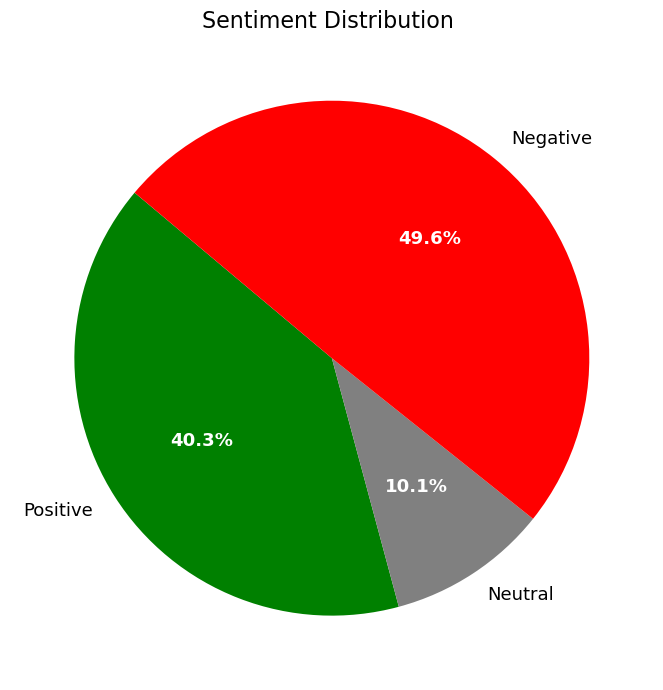

In [20]:
# Get sentiment counts in proper order
labels = ['Positive', 'Neutral', 'Negative']
colors = ['green', 'gray', 'red']
sentiment_counts = df['sentiment'].value_counts()

# Ensure size order matches label order
sizes = [sentiment_counts.get(label, 0) for label in labels]

# Plot the pie chart
plt.figure(figsize=(7, 7))
patches, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 13}
)

# Style the percentage labels
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.title("Sentiment Distribution ", fontsize=16)
plt.tight_layout()
plt.show()

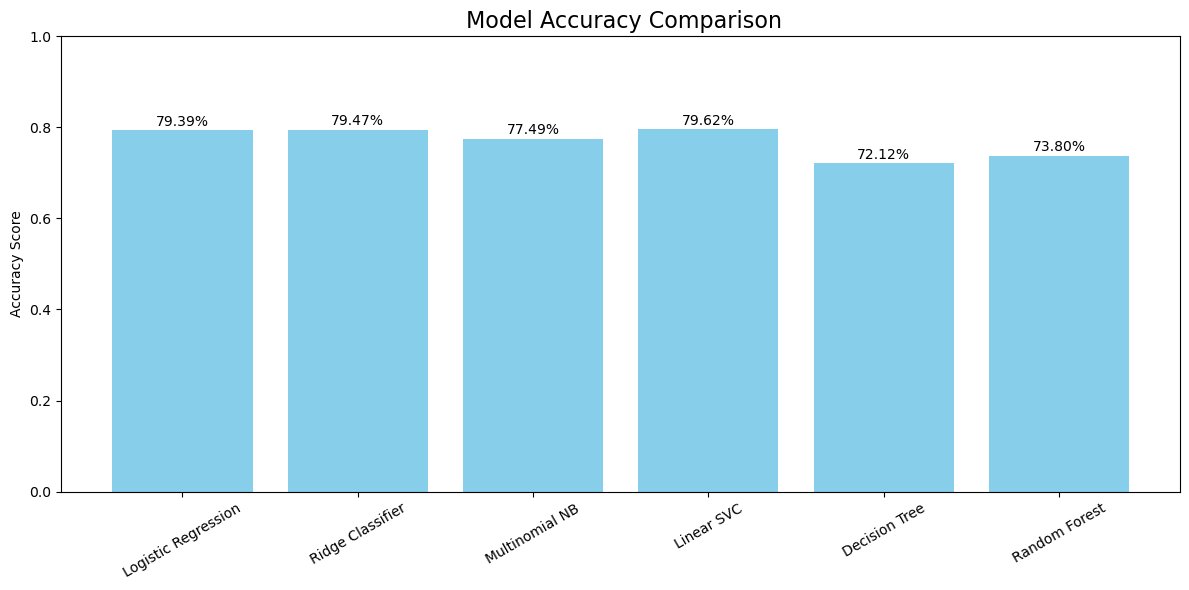

In [21]:
# Accuracy barplot
plt.figure(figsize=(12, 6))
bars = plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.ylim(0, 1)
plt.title(" Model Accuracy Comparison", fontsize=16)
plt.ylabel("Accuracy Score")
plt.xticks(rotation=30)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{bar.get_height():.2%}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

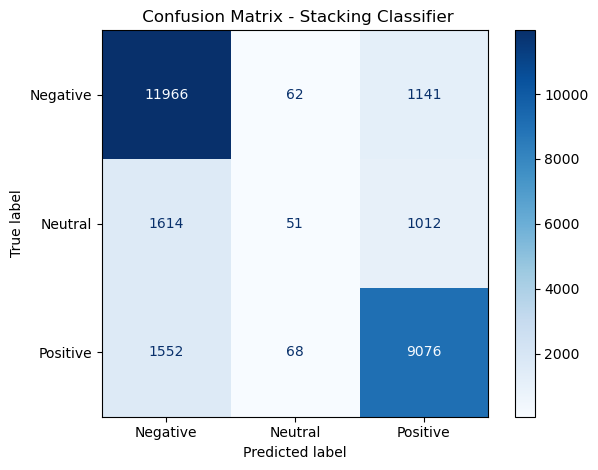

In [22]:
# Predict on test set
stacking_preds = stacking_clf.predict(X_test)

# Plot Confusion Matrix
cm = confusion_matrix(y_test, stacking_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(" Confusion Matrix - Stacking Classifier")
plt.tight_layout()
plt.show()

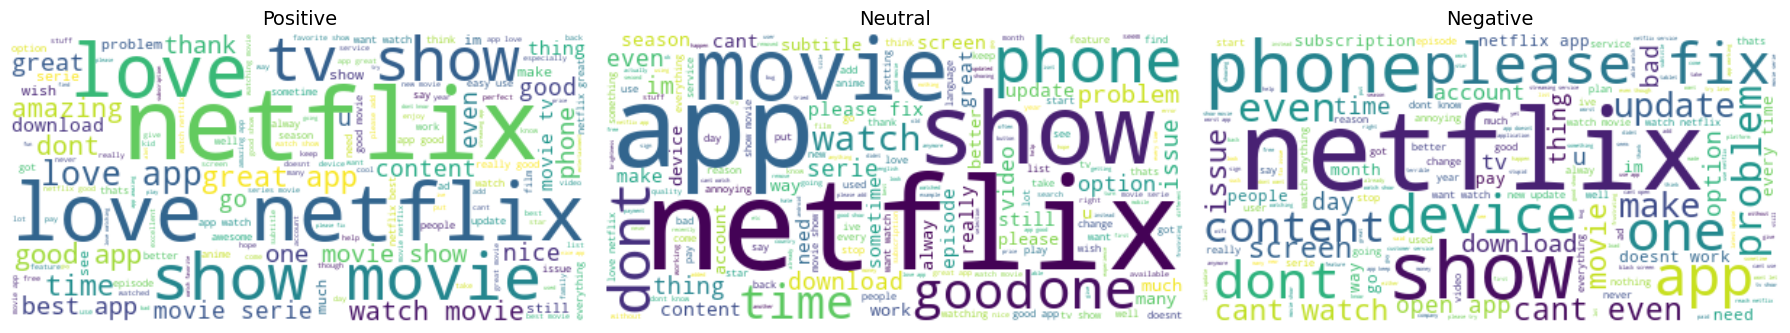

In [23]:
# Word clouds
pos_text = " ".join(df[df['sentiment'] == "Positive"]['cleaned_content'])
neu_text = " ".join(df[df['sentiment'] == "Neutral"]['cleaned_content'])
neg_text = " ".join(df[df['sentiment'] == "Negative"]['cleaned_content'])

wordcloud_pos = WordCloud(background_color='white').generate(pos_text)
wordcloud_neu = WordCloud(background_color='white').generate(neu_text)
wordcloud_neg = WordCloud(background_color='white').generate(neg_text)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].set_title("Positive", fontsize=14)
axes[0].axis('off')
axes[1].imshow(wordcloud_neu, interpolation='bilinear')
axes[1].set_title("Neutral", fontsize=14)
axes[1].axis('off')
axes[2].imshow(wordcloud_neg, interpolation='bilinear')
axes[2].set_title("Negative", fontsize=14)
axes[2].axis('off')
plt.tight_layout()
plt.show()

In [24]:
# Save the trained stacking model
joblib.dump(stacking_clf, 'stacking_sentiment_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

# Save the LabelEncoder
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']